# Building a Baseline Model for MBTI Predictions

## 1) Data Preparation 


### 1.1) What is our dataset?

Our dataset that we will be utilizing for this baseline model is the 'Types 500' MBTI dataset,'(MBTI) Myers-Briggs Personality Type Dataset', and the 'MBTI Personality Type Twitter Dataset' from Kaggle.

For this baseline, we will only use the 'Types 500' as it has already been lightly preproccessed.

In [2]:
# Importing Libraries

import pandas as pd

In [3]:
data = pd.read_csv("Types500.csv")
data.head()

,posts,type
0,know intj tool use interaction people excuse a...,INTJ
1,rap music ehh opp yeah know valid well know fa...,INTJ
2,preferably p hd low except wew lad video p min...,INTJ
3,drink like wish could drink red wine give head...,INTJ
4,space program ah bad deal meing freelance max ...,INTJ


(array([47388.,   650.,  2118.,  3424.,  7701.,  2955., 11906.,   360.,
         2468., 27097.]),
 array([ 0. ,  1.5,  3. ,  4.5,  6. ,  7.5,  9. , 10.5, 12. , 13.5, 15. ]),
 <BarContainer object of 10 artists>)

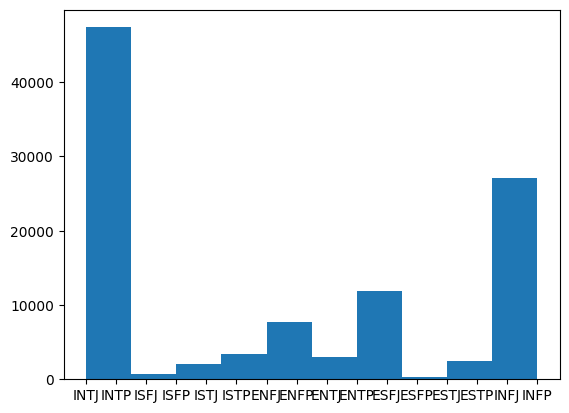

In [37]:
import matplotlib.pyplot as plt

plt.hist(data['type'])

###  1.2) How common are the types according to the MBTI Foundation

The MBTI Foundation has taken 30 years of research to determine the expected  personality types. 

-----
I - 50.7%
 
E - 49.3%
 
N - 26.7%
 
S - 73.3%
 
T - 40.2%
 
F - 59.8%

P - 45.9%
 
J - 54.1%

Let's see how our own dataframe compares

In [4]:
### Compare the class differences 


## This should make columns of binary targets
data['e_i'] = data['type'].astype(str).str[0]
data['s_n'] = data['type'].astype(str).str[1]
data['f_t'] = data['type'].astype(str).str[2]
data['p_j'] = data['type'].astype(str).str[3]


## This should be the percentages of each class
diff_ei = (data['e_i'].value_counts() / data['e_i'].count())
diff_sn = (data['s_n'].value_counts() / data['s_n'].count()) 
diff_ft = (data['f_t'].value_counts() / data['f_t'].count())
diff_pj = (data['p_j'].value_counts() / data['p_j'].count())

diff_data = pd.concat([diff_ei, diff_sn, diff_ft, diff_pj])

for column, val in diff_data.items():
    print(f"{column} is {round(val*100,2)}%")

I is 76.06%
E is 23.94%
N is 91.33%
S is 8.67%
T is 65.24%
F is 34.76%
P is 58.11%
J is 41.89%


Not so close to reality

## 2) Let's Try Models for 'Type'

We will first try to create models that can predict the 16 types of MBTI personalities.


### 2.1) Encoding and Setting X and y
We must define X and y

In [5]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

data['target_type_encoded'] = label_encoder.fit_transform(data['type'])

data.head()

,posts,type,e_i,s_n,f_t,p_j,target_type_encoded
0,know intj tool use interaction people excuse a...,INTJ,I,N,T,J,10
1,rap music ehh opp yeah know valid well know fa...,INTJ,I,N,T,J,10
2,preferably p hd low except wew lad video p min...,INTJ,I,N,T,J,10
3,drink like wish could drink red wine give head...,INTJ,I,N,T,J,10
4,space program ah bad deal meing freelance max ...,INTJ,I,N,T,J,10


In [24]:
X = data['posts']
y = data['target_type_encoded']

### 2.1) Multinomial Naive-Bayes Model with No Parameters

Simple vectorization, then using Multinomial NB to make a model that we can cross validate

In [7]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_validate


count_vectorizer = CountVectorizer()
X_bow = count_vectorizer.fit_transform(X)

model = MultinomialNB()

cv_results = cross_validate(model, X_bow, y, scoring = ['accuracy'])

Let's see our results!

In [8]:
import numpy as np 
np.round(cv_results['test_accuracy'].mean(), 3)

0.674

### 2.2) Deep Learning Model, Tensorflow 
Building a simple Deep Learning Model with Tensorflow and a simple Dense layer

In [9]:
from tensorflow.keras.utils import to_categorical 
y_cat = to_categorical(y, num_classes=16)
y_cat


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [38]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y_cat,
                                                    test_size=.3,
                                                    random_state=0)



In [46]:
X_bla = X_train.apply(lambda x: [w for w in x])
X_bla

In [39]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import pad_sequences


tokenizer = Tokenizer()

tokenizer.fit_on_texts(X_train)
    
X_train_token = tokenizer.texts_to_sequences(X_train)
X_test_token = tokenizer.texts_to_sequences(X_test)

X_train_token_pad_maxlen = pad_sequences(X_train_token, 
                                         dtype = 'float32', 
                                         padding = 'post',
                                         maxlen = 150)

X_test_token_pad_maxlen = pad_sequences(X_test_token, 
                                        dtype = 'float32', 
                                        padding = 'post',
                                        maxlen = 150)

In [11]:
from tensorflow.keras import models, layers

def initialize_model():
    
    # Model Architecture
    
    model = models.Sequential()
    
    model.add(layers.Dense(50, activation='relu', input_dim = 16))

    model.add(layers.Dense(16, activation='sigmoid'))
    
 
    #  Optimization Method
    model.compile(loss='categorical_crossentropy', # different from binary_crossentropy because we have multiple classes
                  optimizer='adam', 
                  metrics=['accuracy']) 

    return model

In [40]:
vocab_size = len(tokenizer.word_index)
vocab_size

209253

In [41]:
from tensorflow.keras import layers, Sequential

embedding_size = 150

model = Sequential()

model.add(layers.Embedding(
    input_dim=vocab_size+1,
    output_dim=embedding_size,
    input_length = 150,
    mask_zero=True))

model.add(layers.Conv1D(20, kernel_size=3))
model.add(layers.Flatten())
model.add(layers.Dense(20, activation = 'relu'))

model.add(layers.Dense(16, activation='sigmoid'))

2023-05-16 21:04:35.423162: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-16 21:04:35.425032: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [43]:
from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(patience=5, restore_best_weights=True)

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model_cnn = model

model_cnn.fit(X_train_token_pad_maxlen, y_train, 
          epochs=20, 
          batch_size=32,
          validation_split=0.3,
          callbacks=[es]
         )


res = model_cnn.evaluate(X_test_token_pad_maxlen, y_test, verbose=0)

print(f'The accuracy evaluated on the test set is of {res[1]*100:.3f}%')

Epoch 1/20
 201/1625 [==>...........................] - ETA: 19:03 - loss: 2.2304 - accuracy: 0.2172

KeyboardInterrupt: 